In [2]:
"""
Copyright (c) 2019-present NAVER Corp.
MIT License
"""

# !pip install opencv  # ! used for command line commands in notebooks

'\nCopyright (c) 2019-present NAVER Corp.\nMIT License\n'

In [3]:
import craft_utils
import imgproc
import file_utils


In [4]:
1# -*- coding: utf-8 -*-
import sys
import os
import time
import argparse

In [5]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

In [6]:
from PIL import Image

In [7]:



import json
import zipfile

In [8]:

import cv2
from skimage import io
import numpy as np

In [9]:
print(cudnn.is_available())
print (torch.cuda.is_available())

True
True


In [10]:
from craft import CRAFT
#!ls


e:\Study\Environments\testlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from collections import OrderedDict
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [12]:
def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [13]:
"""
parser = argparse.ArgumentParser(description='CRAFT Text Detection')
parser.add_argument('--trained_model', default='weights/craft_mlt_25k.pth', type=str, help='pretrained model')
parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold') #0.7
parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
parser.add_argument('--link_threshold', default=0.2, type=float, help='link confidence threshold') #0.2
parser.add_argument('--cuda', default=True, type=str2bool, help='Use cuda for inference')
parser.add_argument('--canvas_size', default=1280, type=int, help='image size for inference')
parser.add_argument('--mag_ratio', default=2.0, type=float, help='image magnification ratio') # 1.5
parser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')
parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
parser.add_argument('--test_folder', default='Data', type=str, help='folder path to input images')
parser.add_argument('--refine', default=False, action='store_true', help='enable link refiner')
parser.add_argument('--refiner_model', default='weights/craft_refiner_CTW1500.pth', type=str, help='pretrained refiner model')
"""

"\nparser = argparse.ArgumentParser(description='CRAFT Text Detection')\nparser.add_argument('--trained_model', default='weights/craft_mlt_25k.pth', type=str, help='pretrained model')\nparser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold') #0.7\nparser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')\nparser.add_argument('--link_threshold', default=0.2, type=float, help='link confidence threshold') #0.2\nparser.add_argument('--cuda', default=True, type=str2bool, help='Use cuda for inference')\nparser.add_argument('--canvas_size', default=1280, type=int, help='image size for inference')\nparser.add_argument('--mag_ratio', default=2.0, type=float, help='image magnification ratio') # 1.5\nparser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')\nparser.add_argument('--show_time', default=False, action='store_true', help='show processing time')\nparser.add_argument('--test_folde

In [14]:
parser = argparse.ArgumentParser(description='CRAFT Text Detection')
parser.add_argument('--trained_model', default='weights/craft_mlt_25k.pth', type=str, help='pretrained model')
parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold') #0.7
parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
parser.add_argument('--link_threshold', default=0.05, type=float, help='link confidence threshold') #0.2  
parser.add_argument('--cuda', default=True, type=str2bool, help='Use cuda for inference')
parser.add_argument('--canvas_size', default=1920, type=int, help='image size for inference')
parser.add_argument('--mag_ratio', default=3.0, type=float, help='image magnification ratio') # 1.5
parser.add_argument('--poly', default=True, action='store_true', help='enable polygon type')
parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
parser.add_argument('--test_folder', default='Data', type=str, help='folder path to input images')
parser.add_argument('--refine', default=True, action='store_true', help='enable link refiner')
parser.add_argument('--refiner_model', default='weights/craft_refiner_CTW1500.pth', type=str, help='pretrained refiner model')

_StoreAction(option_strings=['--refiner_model'], dest='refiner_model', nargs=None, const=None, default='weights/craft_refiner_CTW1500.pth', type=<class 'str'>, choices=None, required=False, help='pretrained refiner model', metavar=None)

In [15]:
args, unknown = parser.parse_known_args()

In [16]:
""" For test images in a folder """
image_list, _, _ = file_utils.get_files(args.test_folder)
print(args.test_folder)

Data


In [17]:
result_folder = './result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

In [18]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    
    for k in range(len(polys)):
        if polys[k] is None:
            polys[k] = boxes[k] 
    
    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text

In [19]:

if __name__ == '__main__':
    # load net
    net = CRAFT()     # initialize

    print('Loading weights from checkpoint (' + args.trained_model + ')')
    if args.cuda:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    if args.cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if args.refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')
        if args.cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        args.poly = True

    t = time.time()

    # load data
    for k, image_path in enumerate(image_list):
        print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
        image = imgproc.loadImage(image_path)

        bboxes, polys, score_text = test_net(net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

        # save score text
        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        mask_file = result_folder + "/res_" + filename + '_mask.jpg'
        cv2.imwrite(mask_file, score_text)

        file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)

    print("elapsed time : {}s".format(time.time() - t))

e:\Study\Environments\testlab\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Study\Environments\testlab\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from checkpoint (weights/craft_mlt_25k.pth)
Loading weights of refiner from checkpoint (weights/craft_refiner_CTW1500.pth)
elapsed time : 61.880696535110474sg6534045397522.jpg


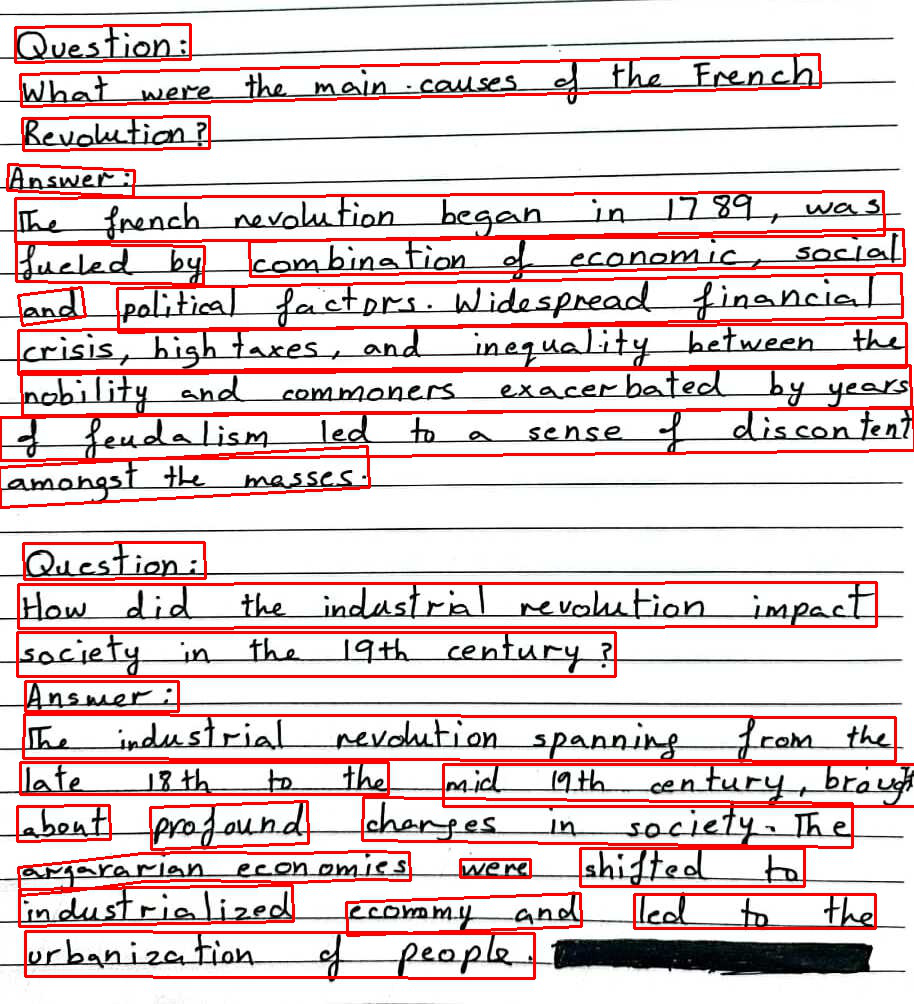

In [28]:
image_path = 'result/res_Multiple_Qs.jpg'
image = Image.open(image_path)
display(image)

In [29]:
def polygon_to_rectangle(polygon):
    # Extract x and y coordinates
    x_coords = polygon[::2]
    y_coords = polygon[1::2]

    # Find minimum and maximum x and y coordinates
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)

    # Construct the rectangle with 8 coordinates
    rectangle = [
        min_x, min_y,  # Top-left corner
        max_x, min_y,  # Top-right corner
        max_x, max_y,  # Bottom-right corner
        min_x, max_y   # Bottom-left corner
    ]

    return rectangle

def read_bounding_boxes_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines_cleaned = [line.strip() for line in lines if line.strip()]
        boxes = []
        for line in lines:
            # Split the line by commas and remove any leading/trailing whitespace
            values = [value.strip() for value in line.strip().split(',') if value.strip()]
            
            # Convert non-empty values to integers
            box = list(map(int, values))
            if(len(box)>8):
                box=polygon_to_rectangle(box)
            
            
            
                
            if box:  # Only append non-empty boxes
                boxes.append(box)
            
    return boxes
 

# Read word-level bounding boxes from a text file
word_boxes = read_bounding_boxes_from_file('result/res_Multiple_Qs.txt')

for i in range(0,len(word_boxes)):
    print(f"{i}:{word_boxes[i]}")



0:[15, 27, 190, 24, 190, 59, 15, 62]
1:[20, 74, 819, 54, 820, 87, 21, 106]
2:[22, 118, 209, 116, 209, 148, 23, 150]
3:[8, 164, 134, 170, 133, 196, 7, 190]
4:[15, 198, 883, 191, 884, 235, 15, 242]
5:[249, 241, 903, 229, 904, 265, 250, 276]
6:[16, 243, 204, 246, 203, 284, 16, 281]
7:[117, 288, 901, 273, 902, 317, 118, 332]
8:[18, 295, 81, 287, 85, 316, 22, 325]
9:[18, 330, 906, 323, 906, 367, 18, 374]
10:[21, 371, 910, 365, 911, 408, 22, 415]
11:[0, 417, 913, 407, 914, 450, 0, 460]
12:[-1, 467, 367, 446, 369, 487, 0, 507]
13:[23, 543, 204, 542, 205, 578, 24, 579]
14:[18, 584, 876, 582, 876, 626, 18, 628]
15:[17, 632, 615, 632, 615, 676, 17, 676]
16:[25, 681, 178, 681, 178, 711, 25, 711]
17:[24, 714, 895, 717, 895, 761, 23, 758]
18:[443, 764, 915, 764, 915, 806, 443, 806]
19:[20, 762, 388, 762, 388, 794, 20, 794]
20:[17, 806, 109, 805, 110, 839, 17, 841]
21:[363, 797, 852, 803, 852, 847, 362, 840]
22:[150, 807, 307, 801, 308, 843, 151, 849]
23:[580, 848, 804, 848, 804, 886, 580, 886]
24:[

In [30]:

from sklearn.cluster import KMeans
def calculate_vertical_gaps(boxes):
    # Sort boxes based on y-coordinate of their top-left corner
    sorted_boxes = sorted(boxes, key=lambda x: (x[1], x[0]))
    
    # Calculate vertical gaps from the top-left corner of each box
    vertical_gaps = [sorted_boxes[i][1] - sorted_boxes[i-1][3] for i in range(1, len(sorted_boxes))]
    
    return vertical_gaps

def dynamic_threshold(vertical_gaps):
 # Convert vertical_gaps to a NumPy array
    print(vertical_gaps)
    vertical_gaps_array = np.array(vertical_gaps).reshape(-1, 1)
    print(vertical_gaps_array)

    # Determine the optimal number of clusters using the elbow method
    distortions = []
    """
    max_clusters = min(len(vertical_gaps), 10)  # Maximum number of clusters to try
    for i in range(3, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(vertical_gaps_array)
        distortions.append(kmeans.inertia_)

    """
    
    """
    # Find the "elbow" point
    deltas = np.diff(distortions)
    elbow_index = np.argmin(deltas) + 1
    print(elbow_index)
    """
   

    

    # Apply K-means clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(vertical_gaps_array)
    
    labels = kmeans.labels_


    first_cluster_indices = np.where(labels == 0)[0]
    first_cluster_data = vertical_gaps_array[first_cluster_indices]
    first_cluster_max = np.max(first_cluster_data)

    """
    # Get cluster centroids
    centroids = kmeans.cluster_centers_
    
    sorted_centroids = np.sort(centroids, axis=0)
    print(sorted_centroids)

    # Choose threshold (e.g., median of centroids)
    threshold = (0.3*sorted_centroids[1] + 0.7*sorted_centroids[0])/2
    """
    threshold= first_cluster_max *1.5
    return threshold



def group_boxes_by_line(boxes, text_threshold):
    lines = []
    current_line = [boxes[0]]
    for box in boxes[1:]:
        if box[1] < current_line[-1][3] + text_threshold:
            current_line.append(box)
        else:
            lines.append(current_line)
            current_line = [box]
    lines.append(current_line)
    
    for line in lines:
        line.sort(key=lambda x: x[0])
    return lines


vertical_gaps=calculate_vertical_gaps(word_boxes)
# Group the word-level bounding boxes into line-level bounding boxes
dynamic_threshold = dynamic_threshold(vertical_gaps) # Adjust this threshold as needed
print(dynamic_threshold)
line_boxes = group_boxes_by_line(word_boxes,dynamic_threshold)

# Now `line_boxes` contains bounding boxes grouped by lines


[50, 64, 48, 28, 50, 14, 42, 22, 43, 48, 52, 60, 97, 42, 50, 49, 33, 45, 2, 33, 3, 2, 47, 3, 8, 30, 9, 8, 38]
[[50]
 [64]
 [48]
 [28]
 [50]
 [14]
 [42]
 [22]
 [43]
 [48]
 [52]
 [60]
 [97]
 [42]
 [50]
 [49]
 [33]
 [45]
 [ 2]
 [33]
 [ 3]
 [ 2]
 [47]
 [ 3]
 [ 8]
 [30]
 [ 9]
 [ 8]
 [38]]
33.0


e:\Study\Environments\testlab\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Study\Environments\testlab\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [31]:
print(line_boxes[0])

[[15, 27, 190, 24, 190, 59, 15, 62]]


In [34]:
from PIL import Image

# Assuming `image_path` is the path to your input image
image_path = 'Data/Multiple_Qs.jpeg'
image = Image.open(image_path)

# Assuming `line_boxes` contains the line-level bounding boxes in the format (x_min, y_min, x_max, y_max)
cropped_images = []
result2=[]
for i, line in enumerate(line_boxes):
  x_min = 9999
  y_min= 9999
  x_max=-9999
  y_max=-9999

  for j, box in enumerate(line):
        # Assuming each box has 4 points
    x_min = min(box[0], box[2], box[4], box[6],x_min)
    y_min = min(box[1], box[3], box[5], box[7],y_min)
    x_max = max(box[0], box[2], box[4], box[6],x_max)
    y_max = max(box[1], box[3], box[5], box[7],y_max)
  result2.append((x_min,y_min,x_max,y_min,x_min,y_max,x_max,y_max))


# Now `cropped_images` contains PIL image objects of the cropped lines.
# You can perform further operations on them.





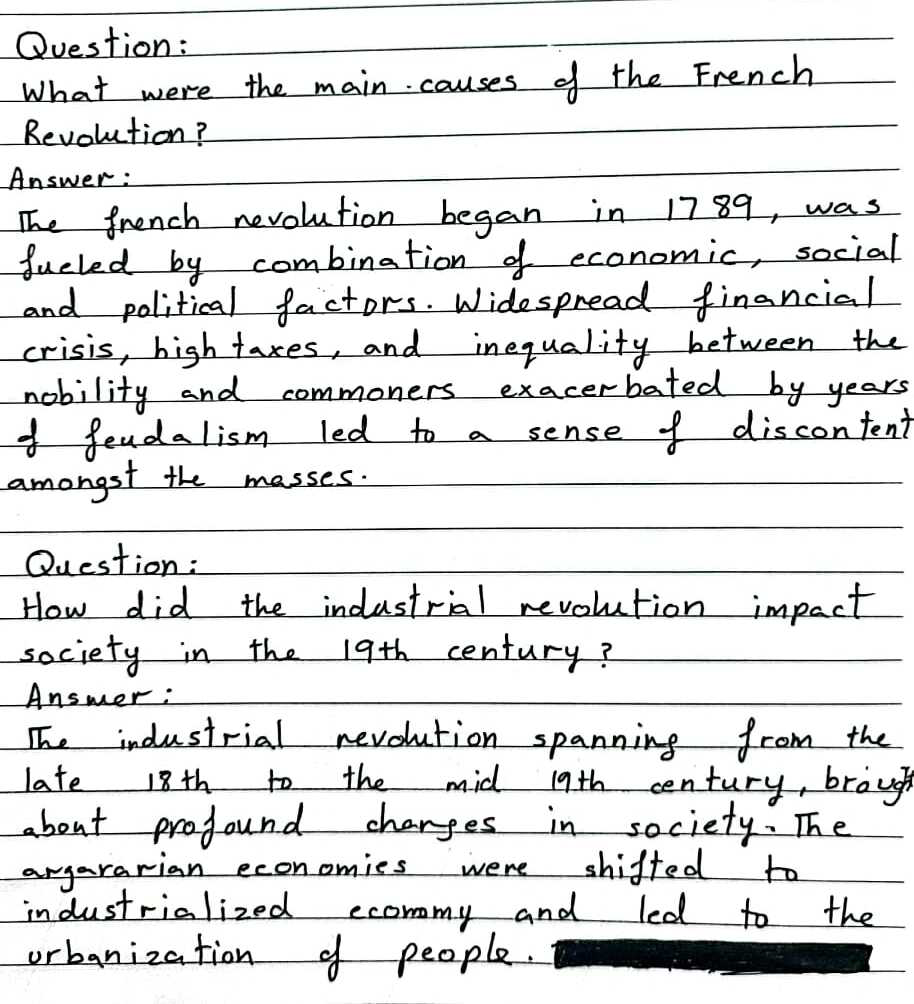

In [35]:
display(image)

In [36]:
img_cropped=[]

for i in range(len(result2)): #len(result2)-1
  x1, y1, x2, y2, x3, y3, x4, y4 = result2[i]
  left = min(x1, x2, x3, x4)
  upper = min(y1, y2, y3, y4)
  right = max(x1, x2, x3, x4)
  lower = max(y1, y2, y3, y4)
 
  img_cropped.append(image.crop((x1, y1, x4, y4)))





In [37]:
for i in range (0,len(img_cropped)):
  img_cropped[i].save(f'Cropped/Test_Image{i}.png',quality=100)



In [38]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
import re

def remove_non_alphabet_characters(input_string):
    result_string = re.sub(r'[^a-zA-Z\s]', '', input_string)
    return result_string

In [40]:
resultant_string =""
from PIL import Image, ImageFilter
from transformers import TrOCRProcessor
for i in range (0,len(img_cropped)):
  image=Image.open(f'Cropped/Test_Image{i}.png')
  sharpened_img = image.filter(ImageFilter.SHARPEN)
  processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
  # calling the processor is equivalent to calling the feature extractor
  pixel_values = processor(sharpened_img, return_tensors="pt").pixel_values

  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  generated_text=remove_non_alphabet_characters(generated_text)
  generated_text=generated_text.strip()
  resultant_string+=generated_text.lower()
  resultant_string+=" "
  print(f"{i}:{generated_text}")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
e:\Study\Environments\testlab\Lib\site-packages\transformers\generation\utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0:Question


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


1:What were the maincauses of the French


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


2:Revolution


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


3:The French revolution began in  was


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


4:fueled by combination of economic social


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


5:and political factors Widespread financial


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


6:crisis high taxes and inequality between the


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


7:nobility and commoners exacerbated by years


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


8:of feudalism led to a sense of discontent


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


9:amongst the masses


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


10:Question


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


11:How did the industrial revolution impact


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


12:society in the th century


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


13:Ansmer


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


14:The industrial revolution spanning from the


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


15:late th to the mid th century brought


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


16:about profound charges in societyThe


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


17:organarian economies were shifted to


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


18:industrialized economy and led to the


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


19:urbanization of people


In [41]:

"""
split_result = resultant_string.split("question")
for i in range (1,len(split_result)):
  temp=split_result[i].split("answer")
  print(f'Question {i}: {temp[0].strip()}')
  print(f'Answer {i}: {temp[1].strip()}')
  """

'\nsplit_result = resultant_string.split("question")\nfor i in range (1,len(split_result)):\n  temp=split_result[i].split("answer")\n  print(f\'Question {i}: {temp[0].strip()}\')\n  print(f\'Answer {i}: {temp[1].strip()}\')\n  '